In [1]:
from dotenv import load_dotenv
import os

from kaggle.api.kaggle_api_extended import KaggleApi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Cargar el archivo .env
load_dotenv()

# Inicializa la API de Kaggle
api = KaggleApi()
api.authenticate()

# Descarga un dataset
dataset = 'stealthtechnologies/predict-student-performance-dataset'

dataset_folder = dataset.split(sep='/')[-1]

output_path = f'datasets/{dataset_folder}/'  # Carpeta de descarga
api.dataset_download_files(dataset, path=output_path, unzip=True)

df = pd.read_csv(f'{output_path}/data.csv')
df

Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/predict-student-performance-dataset


,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0
...,...,...,...,...,...
1383,0.44549,5.5,8.0,51.0,41.0
1384,0.52466,4.9,6.5,63.0,37.0
1385,0.88197,3.9,6.2,54.0,36.0
1386,0.47336,3.5,7.3,61.0,34.0


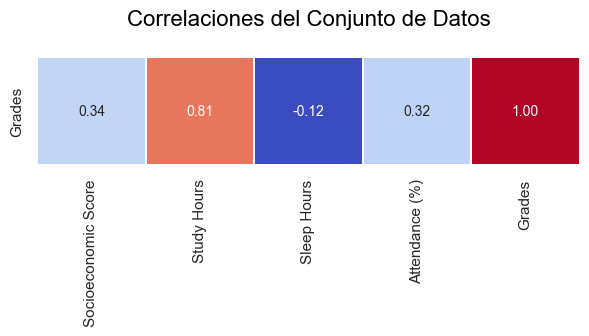

In [2]:
sns.set_theme(font_scale=1)
sns.set_style('white')

cols = df.columns.values
cm = np.corrcoef(df.values.T)

plt.figure(figsize=(7,7))
hm = sns.heatmap(cm[[4]], cbar=False, annot=True, square=True,
                 fmt=".2f", annot_kws={"size":10,},
                 cmap="coolwarm", linewidths=.3, yticklabels=[cols[4]], xticklabels=cols)
hm.set_title('Correlaciones del Conjunto de Datos\n', size=16, color='black')
plt.show()

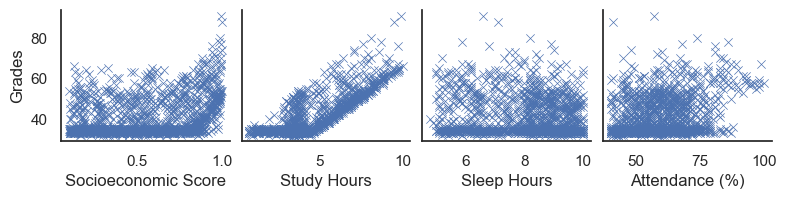

In [3]:
sns.pairplot(data=df,x_vars=cols[:-1],y_vars=['Grades'],height=2.0, aspect=1, markers='x')

In [4]:
x = df.drop('Grades',axis=1)
y = df['Grades']

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.7,random_state=7)

rf = RandomForestRegressor()
model = rf.fit(x_train, y_train)

print('R2 Score - Train: ', model.score(x_train, y_train))
print('R2 Score - Test : ', model.score(x_test, y_test))

R2 Score - Train:  0.9969994757196586
R2 Score - Test :  0.9787799710551544


In [5]:
results = pd.DataFrame(columns=['Dataset'])

results['Real_Grades'] = df['Grades']
results['Model_Predict'] = model.predict(x)

# Añadir la columna 'Dataset' con 'Train' o 'Test'
results['Dataset'] = 'Train'  # Inicializa con 'Train'
results.loc[x_test.index, 'Dataset'] = 'Test'

results['Perc_Accuracy'] = results['Model_Predict']/(results['Real_Grades'])
results['Diff'] = results['Model_Predict'] - results['Real_Grades']

results['Error'] = results['Perc_Accuracy'].apply(
    lambda x: 'Subestimado' if x < 0.95 else 'Preciso' if x <= 1.05 else 'Sobreestimado'
)
results['Error_Diff'] = results['Diff'].apply(
    lambda x: 'Subestimado' if x < -2 else 'Preciso' if x <= 2 else 'Sobreestimado'
)

results

,Dataset,Real_Grades,Model_Predict,Perc_Accuracy,Diff,Error,Error_Diff
0,Train,47.0,46.58,0.991064,-0.42,Preciso,Preciso
1,Train,35.0,35.39,1.011143,0.39,Preciso,Preciso
2,Train,32.0,32.71,1.022188,0.71,Preciso,Preciso
3,Test,34.0,34.17,1.005000,0.17,Preciso,Preciso
4,Train,33.0,33.22,1.006667,0.22,Preciso,Preciso
...,...,...,...,...,...,...,...
1383,Train,41.0,40.58,0.989756,-0.42,Preciso,Preciso
1384,Train,37.0,36.79,0.994324,-0.21,Preciso,Preciso
1385,Test,36.0,39.05,1.084722,3.05,Sobreestimado,Sobreestimado
1386,Train,34.0,34.06,1.001765,0.06,Preciso,Preciso


In [6]:
df_resume = results.groupby(by=['Dataset']).apply(
        lambda group: pd.Series({
            'Subestimado (%)':
            round(100 * len(group[(group['Error'] == 'Subestimado')]) / len(group), 1),
            'Preciso (%)':
            round(100 * len(group[(group['Error'] == 'Preciso')]) / len(group), 1),
            'Sobreestimado (%)':
            round(100 * len(group[(group['Error'] == 'Sobreestimado')]) / len(group), 1),
        }), include_groups=False
    ).reset_index()

df_resume

,Dataset,Subestimado (%),Preciso (%),Sobreestimado (%)
0,Test,3.1,92.1,4.8
1,Train,0.1,99.8,0.1


In [7]:
df_resume = results.groupby(by=['Dataset']).apply(
        lambda group: pd.Series({
            'Subestimado (%)':
            round(100 * len(group[(group['Error_Diff'] == 'Subestimado')]) / len(group), 1),
            'Preciso (%)':
            round(100 * len(group[(group['Error_Diff'] == 'Preciso')]) / len(group), 1),
            'Sobreestimado (%)':
            round(100 * len(group[(group['Error_Diff'] == 'Sobreestimado')]) / len(group), 1),
        }), include_groups=False
    ).reset_index()

df_resume

,Dataset,Subestimado (%),Preciso (%),Sobreestimado (%)
0,Test,4.8,89.7,5.5
1,Train,0.4,99.3,0.3
